# **Analyse des données ratings IMDB 🍿📹**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

On évalue l'état général du dataframe

In [2]:
df_ratings_imdb=pd.read_parquet('/Users/gustavetremey/Desktop/projet_python_films/projet_python_films/Data processing/data_IMDB_TMDB_join.parquet')
df_ratings_imdb.describe()

,averageRating_IMDB,numVotes_IMDB,isAdult,release_year,runtimeMinutes,tmdb_id,popularity_TMDB,budget,revenue,vote_average_TMDB,vote_count_TMDB
count,265654.000000,2.656540e+05,265654.000000,265654.0,265654.000000,2.386000e+05,238600.000000,2.386000e+05,2.386000e+05,238600.000000,238600.000000
mean,6.137748,4.262008e+03,0.012806,1996.85011,94.819054,4.649139e+05,1.624841,1.154117e+06,2.913961e+06,4.277066,93.032313
std,1.338916,4.012163e+04,0.112437,26.015858,157.845798,3.782425e+05,2.684879,9.382142e+06,3.318591e+07,2.775274,740.998257
min,1.000000,5.000000e+00,0.000000,1894.0,1.000000,2.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,5.300000,2.500000e+01,0.000000,1980.0,81.000000,1.552075e+05,0.157900,0.000000e+00,0.000000e+00,1.500000,1.000000
50%,6.200000,8.800000e+01,0.000000,2007.0,91.000000,3.759135e+05,1.353000,0.000000e+00,0.000000e+00,5.077000,3.000000
75%,7.000000,4.350000e+02,0.000000,2017.0,104.000000,6.626568e+05,2.386225,0.000000e+00,0.000000e+00,6.300000,13.000000
max,10.000000,3.128869e+06,1.000000,2025.0,59460.000000,1.593344e+06,458.174400,5.839000e+08,2.923706e+09,10.000000,38336.000000


In [3]:
df_ratings_imdb.rename(columns={'averageRating_IMDB':'averageRating', 'numVotes_IMDB':'numVotes'}, inplace=True)
df_ratings_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265654 entries, 0 to 265653
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tconst                265654 non-null  object 
 1   averageRating         265654 non-null  float64
 2   numVotes              265654 non-null  int64  
 3   originalTitle         265654 non-null  object 
 4   isAdult               265654 non-null  int64  
 5   release_year          265654 non-null  Int64  
 6   runtimeMinutes        265654 non-null  float64
 7   genres                265654 non-null  object 
 8   director_name         265654 non-null  object 
 9   primaryProfession     265654 non-null  object 
 10  tmdb_id               238600 non-null  float64
 11  original_language     238600 non-null  object 
 12  popularity_TMDB       238600 non-null  float64
 13  overview              238600 non-null  object 
 14  budget                238600 non-null  float64
 15  

---

# **Analyse individuelle des variables**

### Nombre d'avis

In [4]:
df_ratings_imdb['numVotes'].describe()

count    2.656540e+05
mean     4.262008e+03
std      4.012163e+04
min      5.000000e+00
25%      2.500000e+01
50%      8.800000e+01
75%      4.350000e+02
max      3.128869e+06
Name: numVotes, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


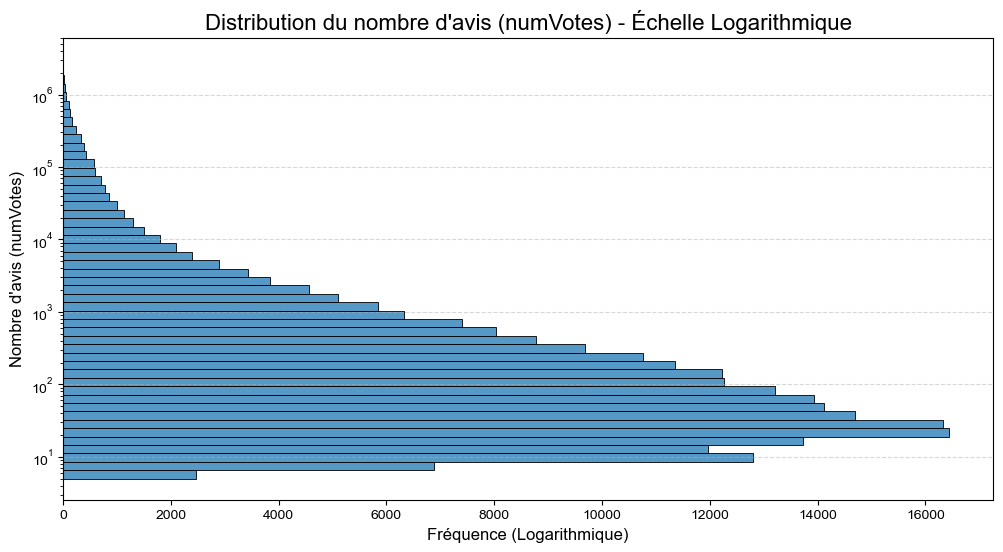

In [5]:
# Histogramme de la distribution du nombre de votes IMDB 
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb,
    y='numVotes',
    bins=50,
    log_scale=(False, True)  #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre d'avis (numVotes) - Échelle Logarithmique", fontsize=16)
plt.ylabel("Nombre d'avis (numVotes)", fontsize=12)
plt.xlabel("Fréquence (Logarithmique)", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

*La distribution semble centrée vers 50, avec un décalage vers des films moins notés. On prend le parti de conserver tous ces films pour l'instant, afin de garder un groupe représentatif et divers. Le critère du nombre de votes n'est toutefois pas éliminé dans la sélection par la suite.*

*On teste sur les films à plus de 10 000 avis pour avoir une idée de la distribution sur des films de moyenne et plus grande ampleur*

In [6]:
mask = df_ratings_imdb['numVotes'] >= 10000
df_ratings_imdb_new=df_ratings_imdb.loc[mask]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


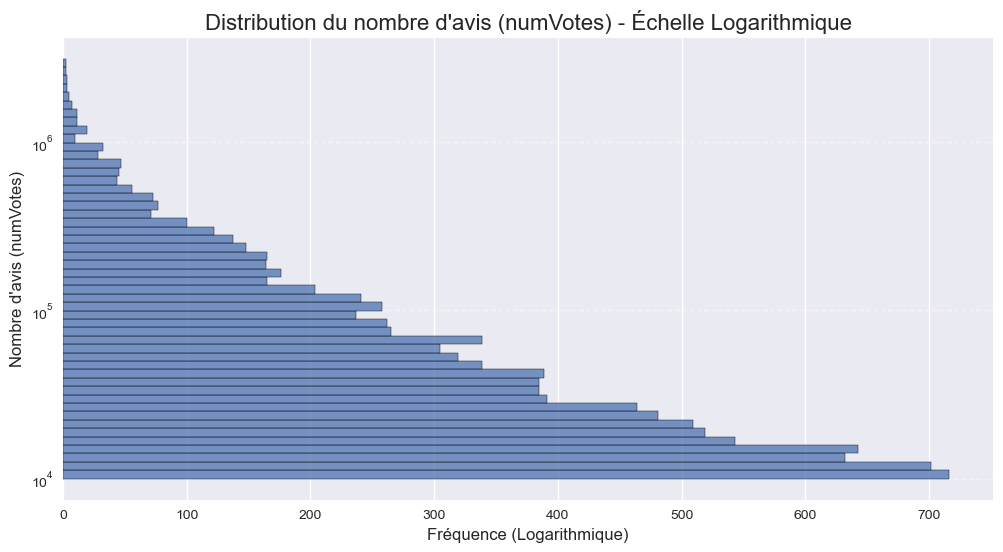

In [7]:
# Histogramme de la distribution du nombre de votes IMDB, supérieurs à 4000
plt.figure(figsize=(12, 6))

sns.histplot(
    data=df_ratings_imdb_new,
    y='numVotes',
    bins=50,
    log_scale=(False, True)  #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre d'avis (numVotes) - Échelle Logarithmique", fontsize=16)
plt.ylabel("Nombre d'avis (numVotes)", fontsize=12)
plt.xlabel("Fréquence (Logarithmique)", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

*Naturellement, il y a moins de films très connus que de films moins connus, la distribution est donc non centrée. On prend néanmoins le parti de la diversité en gardant des films relativement notés, dès 10 000 avis pour notre algorithme de recommandation.*

####

### Ratings

On évalue désormais la distribution des notes des films, entre 0 et 10

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


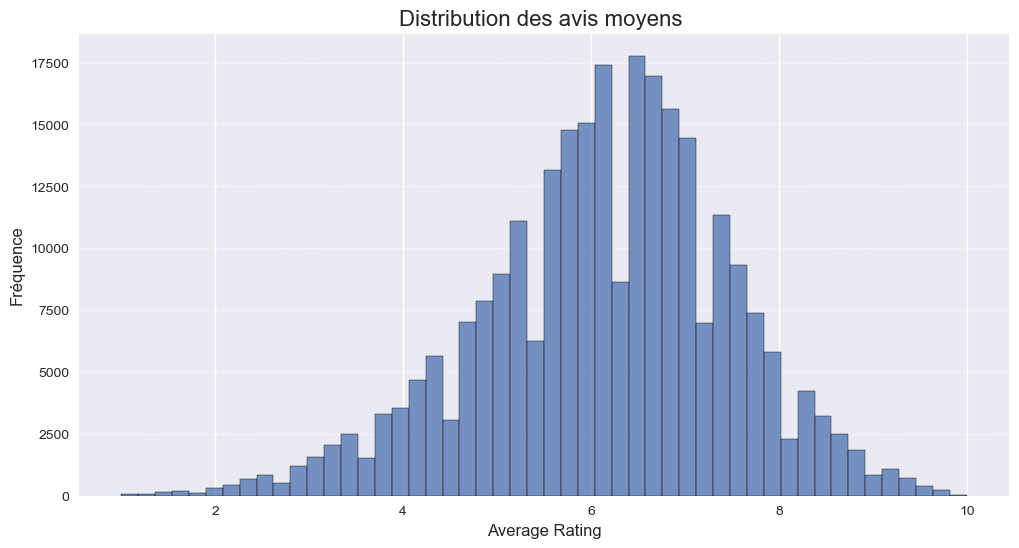

In [8]:
# Histogramme de la distribution du nombre d'avis moyens IMDB
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb,
    x='averageRating',
    bins=50  )

plt.title("Distribution des avis moyens ", fontsize=16)
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

### Genres

Un premier formattage est nécessaire pour placer les genres de films sous forme de liste et les séparer quand ils sont plusieurs, afin de pouvoir les quantifier correctement dans les analyses. Par exemple, ne pas sortir un genre Romance, Aventure mais distinguer les deux en même temps.

In [9]:
#Répartition des genres
df_ratings_imdb_genres=df_ratings_imdb.copy()
df_ratings_imdb_genres['genres']=df_ratings_imdb_genres['genres'].astype(str)
df_ratings_imdb_genres['genres']=df_ratings_imdb_genres['genres'].str.split(',')
df_ratings_imdb_genres=df_ratings_imdb_genres.explode('genres')
df_ratings_imdb_genres

,tconst,averageRating,numVotes,originalTitle,isAdult,release_year,runtimeMinutes,genres,director_name,primaryProfession,...,original_language,popularity_TMDB,overview,budget,country,production_companies,revenue,vote_average_TMDB,vote_count_TMDB,cast
0,tt0000009,5.2,231,Miss Jerry,0,1894,45.0,Romance,Alexander Black,"director,writer,cinematographer",...,en,0.2544,The adventures of a female reporter in the 1890s.,0.0,[US],['Alexander Black Photoplays'],0.0,4.5,4.0,"[{'name': 'Blanche Bayliss', 'gender': 0, 'pop..."
1,tt0000147,5.3,578,The Corbett-Fitzsimmons Fight,0,1897,100.0,Documentary,Enoch J. Rector,"director,cinematographer,editor",...,en,0.0511,"This legendary fight was filmed on March 17, 1...",0.0,[US],['Veriscope Company'],0.0,5.3,27.0,"[{'name': 'James J. Corbett', 'gender': 2, 'po..."
1,tt0000147,5.3,578,The Corbett-Fitzsimmons Fight,0,1897,100.0,News,Enoch J. Rector,"director,cinematographer,editor",...,en,0.0511,"This legendary fight was filmed on March 17, 1...",0.0,[US],['Veriscope Company'],0.0,5.3,27.0,"[{'name': 'James J. Corbett', 'gender': 2, 'po..."
1,tt0000147,5.3,578,The Corbett-Fitzsimmons Fight,0,1897,100.0,Sport,Enoch J. Rector,"director,cinematographer,editor",...,en,0.0511,"This legendary fight was filmed on March 17, 1...",0.0,[US],['Veriscope Company'],0.0,5.3,27.0,"[{'name': 'James J. Corbett', 'gender': 2, 'po..."
2,tt0000574,6.0,1039,The Story of the Kelly Gang,0,1906,70.0,Action,Charles Tait,"director,writer",...,en,0.1518,Just as Galeen and Wegener's Der Golem (1915) ...,0.0,[AU],"['Johnson and Gibson', 'J. & N. Tait']",0.0,5.2,40.0,"[{'name': 'Elizabeth Tait', 'gender': 0, 'pop'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265651,tt9916362,6.4,6167,Akelarre,0,2020,92.0,Drama,Pablo Agüero,"director,writer,producer",...,eu,2.4468,"French Basque Country, year 1609. The men of a...",0.0,[ES],"['INCAA', 'La Fidèle Production', 'Lamia Produ...",0.0,6.7,306.0,"[{'name': 'Àlex Brendemühl', 'gender': 2, 'pop..."
265651,tt9916362,6.4,6167,Akelarre,0,2020,92.0,History,Pablo Agüero,"director,writer,producer",...,eu,2.4468,"French Basque Country, year 1609. The men of a...",0.0,[ES],"['INCAA', 'La Fidèle Production', 'Lamia Produ...",0.0,6.7,306.0,"[{'name': 'Àlex Brendemühl', 'gender': 2, 'pop..."
265651,tt9916362,6.4,6167,Akelarre,0,2020,92.0,Horror,Pablo Agüero,"director,writer,producer",...,eu,2.4468,"French Basque Country, year 1609. The men of a...",0.0,[ES],"['INCAA', 'La Fidèle Production', 'Lamia Produ...",0.0,6.7,306.0,"[{'name': 'Àlex Brendemühl', 'gender': 2, 'pop..."
265652,tt9916538,7.6,12,Kuambil Lagi Hatiku,0,2019,123.0,Drama,Azhar Kinoi Lubis,"director,assistant_director,actor",...,id,2.1100,"Agra City, India, will be the witness to the m...",0.0,[ID],"['Perusahaan Film Negara', 'Taman Wisata Candi...",0.0,0.0,0.0,"[{'name': 'Lala Karmela', 'gender': 1, 'pop': ..."


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


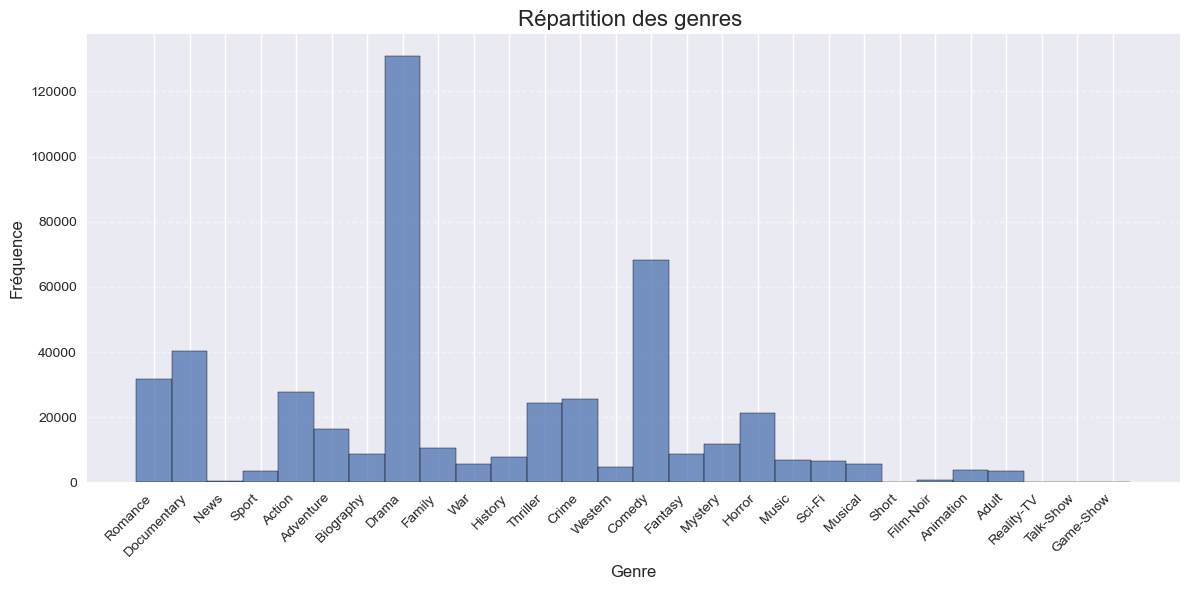

In [10]:
# Histogramme de la distribution des genres de films
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb_genres,
    x='genres',
    bins=50  
)

plt.title("Répartition des genres ", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.style.use('seaborn-v0_8')
plt.show()

*On observe une surreprésentation du genre drama et comedy, on les retire pour observer la distribution des autres catégories*

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


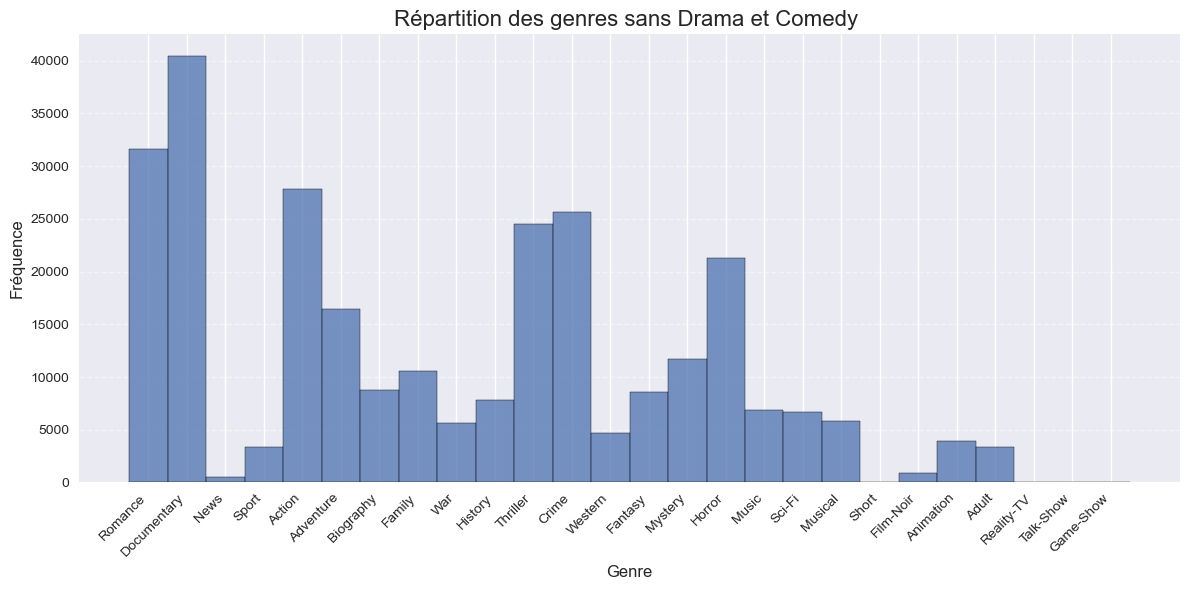

In [11]:
mask_genres = (df_ratings_imdb_genres['genres'] != 'Comedy') &(df_ratings_imdb_genres['genres'] != 'Drama')

# Histogramme de la distribution du nombre de votes IMDB 
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb_genres[mask_genres],
    x='genres',
    bins=50  #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Répartition des genres sans Drama et Comedy ", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.style.use('seaborn-v0_8')
plt.show()

*Certains genres prédominent clairement, on remarque surtout de faibles valeurs au niveau de news, talk show, game-show, short et film noir. Ces genres restent marginaux dans notre but de recommandation de films. Leur proportion empirique ne semble pas anormale non plus.*

##### 

### Réalisateurs

In [12]:
## Classement des réalisateurs avec plus de 20 films dans le dataset
df_ratings_imdb_directors = df_ratings_imdb.copy()
df_ratings_imdb_directors['director_name'] = df_ratings_imdb_directors['director_name'].astype(str)
df_ratings_imdb_directors['director_name'] = df_ratings_imdb_directors['director_name'].str.split(',')
df_ratings_imdb_directors = df_ratings_imdb_directors.explode('director_name')
df_ratings_imdb_directors

# compter les films par réalisateur (index = nom du réalisateur)
director_counts = df_ratings_imdb_directors['director_name'].value_counts()

# sélection des réalisateurs ayant >= 20 films (Index de noms)
mask_20_films = director_counts >= 20
directors_20_films = director_counts[mask_20_films].index

# (optionnel) DataFrame contenant uniquement les lignes des réalisateurs avec >= 20 films
df_directors_20_films = df_ratings_imdb_directors[df_ratings_imdb_directors['director_name'].isin(directors_20_films)]
df_directors_20_films=df_directors_20_films.groupby('director_name').agg(moyenne_numVotes=('numVotes', 'mean'),
                                                  moyenne_Rating=('averageRating', 'mean'))

df_directors_20_films=pd.merge(df_directors_20_films,director_counts, on='director_name',how='left')

df_directors_20_films


,moyenne_numVotes,moyenne_Rating,count
director_name,,,
A. Bhimsingh,106.840000,7.036000,25
A. Edward Sutherland,610.767442,5.900000,43
A. Kodandarami Reddy,163.395349,6.862791,43
A. Razak Mohaideen,69.390244,5.102439,41
Aarne Tarkas,105.000000,5.574194,31
...,...,...,...
Çetin Inanç,256.066667,5.064444,45
Édouard Molinaro,1515.272727,6.160606,33
Éric Rohmer,6168.240000,7.144000,25


In [13]:
df_directors_20_films_famous=df_directors_20_films.copy()
df_directors_20_films_famous=df_directors_20_films_famous.loc[df_directors_20_films_famous['moyenne_numVotes']>10000]
df_directors_20_films_famous

,moyenne_numVotes,moyenne_Rating,count
director_name,,,
Akira Kurosawa,50570.214286,7.553571,28
Alfred Hitchcock,79434.566038,6.883019,53
Barry Levinson,63295.851852,6.385185,27
Billy Wilder,62358.600000,7.448000,25
Blake Edwards,16976.078947,6.289474,38
...,...,...,...
William Wyler,17330.804348,6.769565,46
Wilson Yip,22151.956522,6.152174,23
Wim Wenders,16209.387097,6.687097,31


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


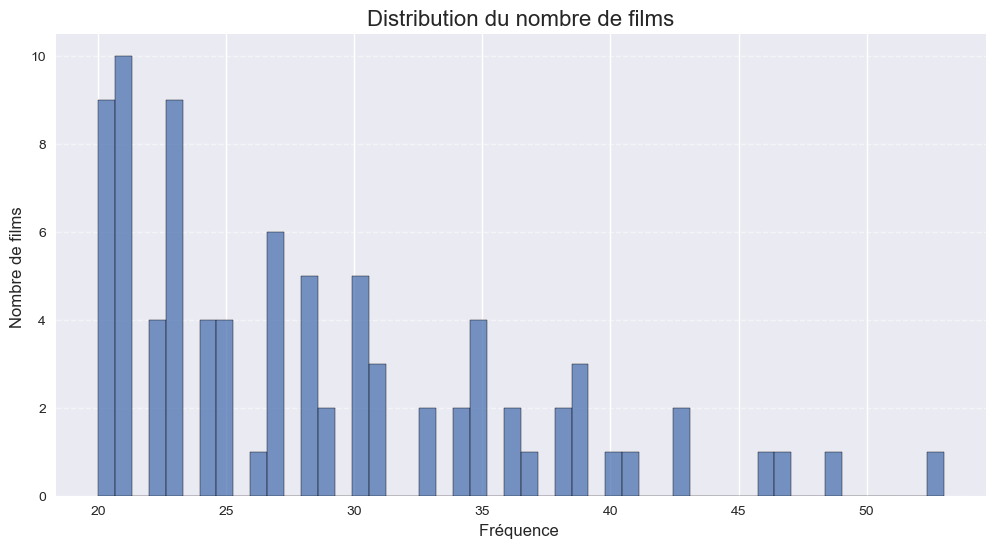

In [14]:
# Histogramme de la distribution des films par réalisateur (avec plus de 20 films et plus de 10 000 votes moyens)
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_directors_20_films_famous,
    x='count',
    bins=50,
      #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre de films", fontsize=16)
plt.ylabel("Nombre de films ", fontsize=12)
plt.xlabel("Fréquence ", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


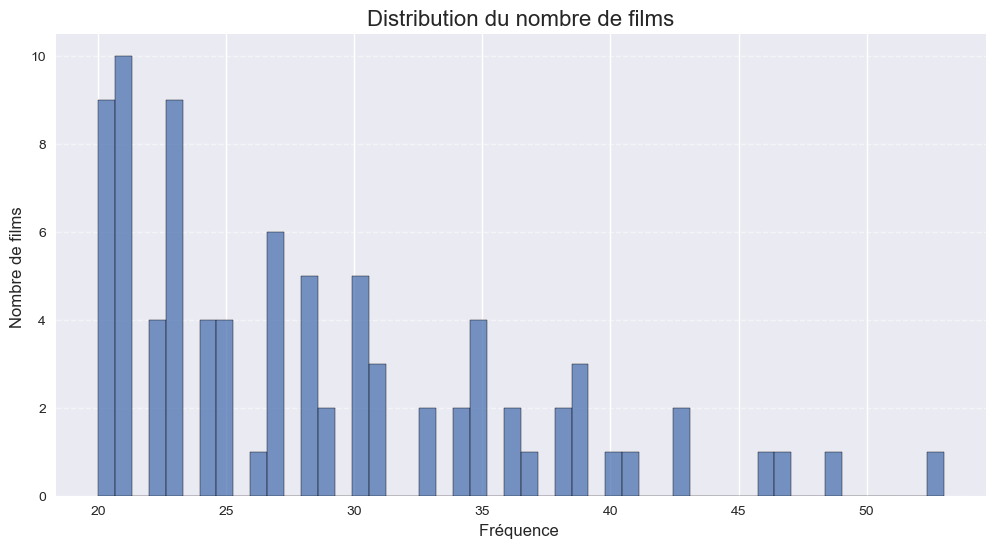

In [15]:
# Histogramme de la distribution des films par réalisateur (avec plus de 20 films et plus de 10 000 votes moyens)
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_directors_20_films_famous,
    x='count',
    bins=50,
      #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre de films", fontsize=16)
plt.ylabel("Nombre de films ", fontsize=12)
plt.xlabel("Fréquence ", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

### Années de sortie

In [16]:
df_ratings_imdb['release_year'].describe()

count      265654.0
mean     1996.85011
std       26.015858
min          1894.0
25%          1980.0
50%          2007.0
75%          2017.0
max          2025.0
Name: release_year, dtype: Float64

Pour des films débutant en 1894 dans le dataframe, on remarque une distribution bien plus concentrée sur les 20-30 dernières années observées. L'essor de la production cinématographique justifie particulièrement cette concentration récente.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


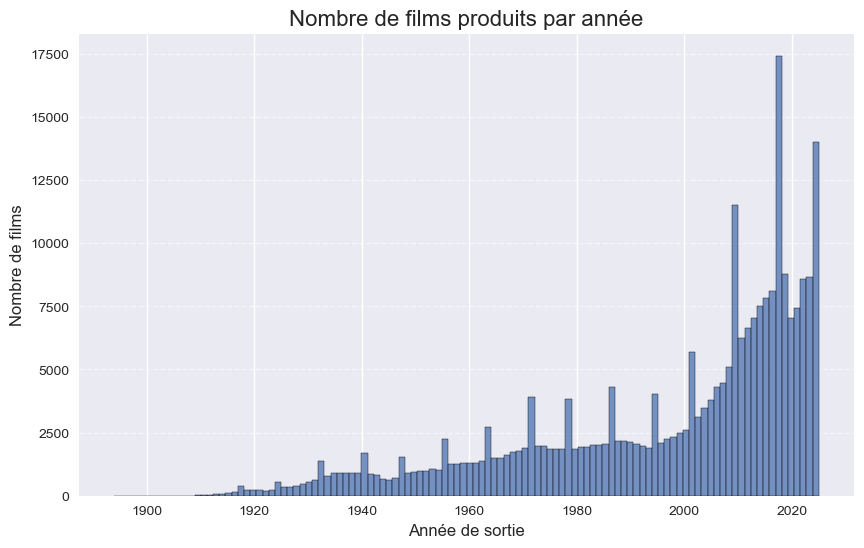

In [17]:
plt.figure(figsize=(10,6))


sns.histplot(
    data=df_ratings_imdb,
    x='release_year'
)

plt.xlabel("Année de sortie", fontsize=12)
plt.ylabel("Nombre de films", fontsize=12)
plt.title("Nombre de films produits par année", fontsize=16)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

On se concentre ici brièvement sur l'intervalle de temps 1990-2025 pour observer des valeurs particulières.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


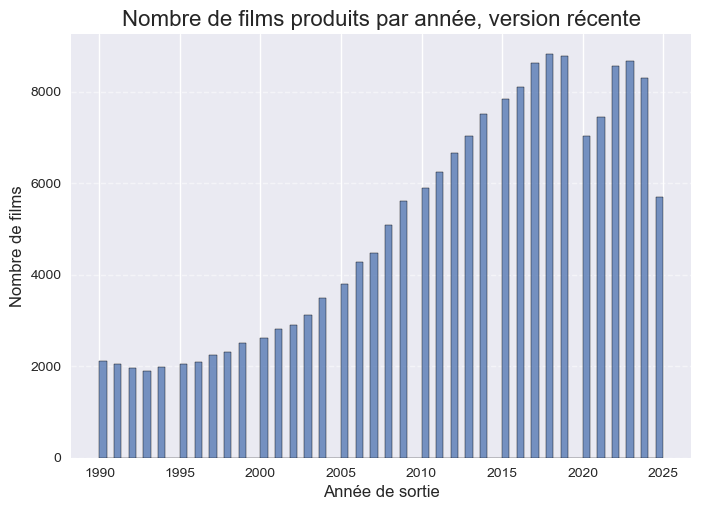

In [18]:
recent_movies=df_ratings_imdb['release_year']>=1990

df_recent_movies=df_ratings_imdb[recent_movies]

sns.histplot(
    data=df_recent_movies,
    x='release_year'
)

plt.xlabel("Année de sortie", fontsize=12)
plt.ylabel("Nombre de films", fontsize=12)
plt.title("Nombre de films produits par année, version récente", fontsize=16)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

# **Approfondissement, analyse croisée**

On produit maintenant une matrice de corrélation entre les facteurs du tableau afin de tester la pertinence des facteurs pour en prédire d'autres

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


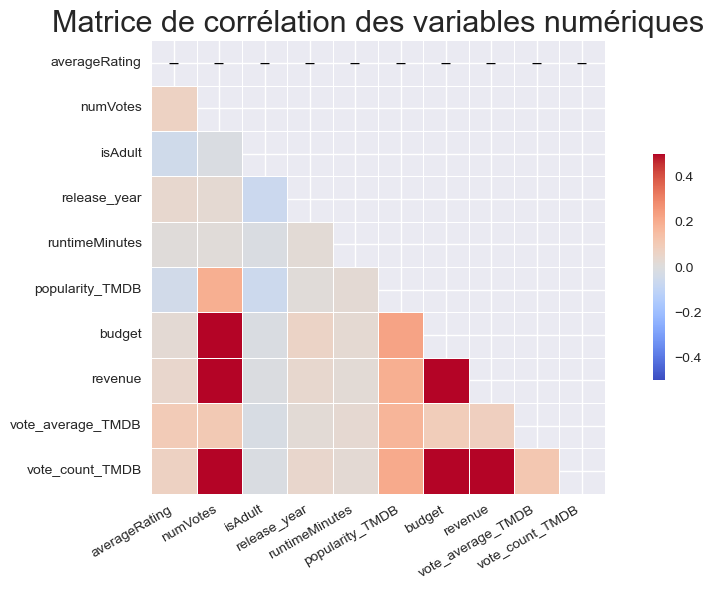

In [19]:
column_labels=df_ratings_imdb.columns.tolist()
list_columns_object = [
    "tconst",
    "originalTitle",
    "genres",
    "director_name",
    "primaryProfession",
    "original_language",
    "overview",
    "country",
    "production_companies",
    "cast"
]
list_columns_object.append('tmdb_id') #classement des IDS par ordre chrnologique non pertinent pour les corrélations

corr=(df_ratings_imdb.drop(list_columns_object, axis=1).corr().dropna(how='all').dropna(axis=1, how='all'))

mask=np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)]=True

fig=plt.figure(figsize=(10,6))



g = sns.heatmap(
    corr,
    mask=mask,     # Mask upper triangular matrix
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmax=.5,
    vmin=-.5,
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   
    linewidths=0.5, 
    cbar_kws={"shrink": .5},
    annot_kws={"size":12, "color":"black"} 
)



plt.title("Matrice de corrélation des variables numériques", fontsize=22)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Preprocessing global

On fait ici le choix de la standardisation plutôt que de la normalisation pour le traitement des données, au vu du nombre conséquent d'outliers et de valeurs significativement éloignées.

In [20]:
#################################Standardisation des données numériques################
# Sélection des colonnes à transformer
cols_to_scale = ['budget', 'revenue', 'popularity_TMDB', 'numVotes']

# Il est important de traiter les valeurs manquantes avant le scaling
df_ratings_imdb[cols_to_scale] = df_ratings_imdb[cols_to_scale].fillna(0)

scaler_std=StandardScaler()

df_std=df_ratings_imdb.copy()
df_std[cols_to_scale]=scaler_std.fit_transform(df_std[cols_to_scale])
df_std.describe()

,averageRating,numVotes,isAdult,release_year,runtimeMinutes,tmdb_id,popularity_TMDB,budget,revenue,vote_average_TMDB,vote_count_TMDB
count,265654.000000,2.656540e+05,265654.000000,265654.0,265654.000000,2.386000e+05,2.656540e+05,2.656540e+05,2.656540e+05,238600.000000,238600.000000
mean,6.137748,9.575399e-18,0.012806,1996.85011,94.819054,4.649139e+05,-7.296561e-17,2.714813e-18,3.744569e-18,4.277066,93.032313
std,1.338916,1.000002e+00,0.112437,26.015858,157.845798,3.782425e+05,1.000002e+00,1.000002e+00,1.000002e+00,2.775274,740.998257
min,1.000000,-1.061028e-01,0.000000,1894.0,1.000000,2.000000e+00,-5.631346e-01,-1.164908e-01,-8.318358e-02,0.000000,0.000000
25%,5.300000,-1.056043e-01,0.000000,1980.0,81.000000,1.552075e+05,-5.367793e-01,-1.164908e-01,-8.318358e-02,1.500000,1.000000
50%,6.200000,-1.040341e-01,0.000000,2007.0,91.000000,3.759135e+05,-1.363369e-01,-1.164908e-01,-8.318358e-02,5.077000,3.000000
75%,7.000000,-9.538534e-02,0.000000,2017.0,104.000000,6.626568e+05,3.065519e-01,-1.164908e-01,-8.318358e-02,6.300000,13.000000
max,10.000000,7.787851e+01,1.000000,2025.0,59460.000000,1.593344e+06,1.762352e+02,6.550196e+01,9.284200e+01,10.000000,38336.000000


On encode les colonnes non numériques. Le parti de conserver les 10 catégories les plus fréquentes évite un bruit trop fort dans l'analyse; on étend juste pour les compagnies de production, pour éviter de se restreindre aux grosses productions.

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

columns_to_process=['genres','original_language','primaryProfession','production_companies']

def encode_multilabel_column(df,column, top_n):
    """
    Nettoie, filtre le Top N et encode une colonne multi-label.
    """
    print(f"Traitement de la colonne : {column}...")
    
    # a. Transformation des chaînes "A, B" en listes réelles ["A", "B"]
    # On gère les NaN en les remplaçant par une liste vide
    temp_series = df[column].fillna('').str.split(',')
    
    # b. Identification du Top N des catégories les plus fréquentes
    # .explode() sépare chaque élément de la liste sur une ligne propre pour le comptage
    top_categories = temp_series.explode().value_counts().head(top_n).index.tolist()
    
    # c. Filtrage : on ne garde que les éléments appartenant au Top N
    filtered_series = temp_series.apply(
        lambda x: [item for item in x if item in top_categories]
    )
    
    # d. Application du MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    encoded_data = mlb.fit_transform(filtered_series)
    
    # e. Création du DataFrame avec préfixe pour éviter les collisions de noms (ex: 'genres_Action')
    encoded_df = pd.DataFrame(
        encoded_data, 
        columns=[f"{column}_{cls}" for cls in mlb.classes_],
        index=df.index
    )
    
    return encoded_df

df_final = df_std.copy()

top_n = 10  # Nombre de catégories à conserver pour chaque colonne
for col in columns_to_process:
    if col in df_final.columns:
        if col=='production_companies':
            top_n=30    #balayage plus large pour les compagnies de production
        # Générer les colonnes encodées
        df_encoded_part = encode_multilabel_column(df_final, col, top_n=top_n)
        
        # Joindre au DataFrame principal
        df_final = pd.concat([df_final, df_encoded_part], axis=1)
        


print("\nEncodage terminé !")
print(f"Nouvelles dimensions du DataFrame : {df_final.shape}")

Traitement de la colonne : genres...
Traitement de la colonne : original_language...
Traitement de la colonne : primaryProfession...
Traitement de la colonne : production_companies...

Encodage terminé !
Nouvelles dimensions du DataFrame : (265654, 81)


In [22]:
df_final

,tconst,averageRating,numVotes,originalTitle,isAdult,release_year,runtimeMinutes,genres,director_name,primaryProfession,...,production_companies_['Paramount Pictures'],production_companies_['RKO Radio Pictures'],production_companies_['Republic Pictures'],production_companies_['Shaw Brothers'],production_companies_['Shochiku'],production_companies_['Toei Company'],production_companies_['Universal Pictures',production_companies_['Universal Pictures'],production_companies_['Warner Bros. Pictures'],production_companies_[]
0,tt0000009,5.2,-0.100470,Miss Jerry,0,1894,45.0,Romance,Alexander Black,"director,writer,cinematographer",...,0,0,0,0,0,0,0,0,0,0
1,tt0000147,5.3,-0.091821,The Corbett-Fitzsimmons Fight,0,1897,100.0,"Documentary,News,Sport",Enoch J. Rector,"director,cinematographer,editor",...,0,0,0,0,0,0,0,0,0,0
2,tt0000574,6.0,-0.080331,The Story of the Kelly Gang,0,1906,70.0,"Action,Adventure,Biography",Charles Tait,"director,writer",...,0,0,0,0,0,0,0,0,0,0
3,tt0000591,4.8,-0.105330,L'enfant prodigue,0,1907,90.0,Drama,Michel Carré,"director,writer,actor",...,0,0,0,0,0,0,0,0,0,0
4,tt0001285,5.2,-0.104408,The Life of Moses,0,1909,50.0,"Biography,Drama,Family",J. Stuart Blackton,"director,producer,miscellaneous",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265649,tt9916190,3.6,-0.099598,Safeguard,0,2020,95.0,"Action,Adventure,Thriller",Fraser Precious,"producer,director,writer",...,0,0,0,0,0,0,0,0,0,1
265650,tt9916270,5.8,-0.068093,Il talento del calabrone,0,2020,84.0,Thriller,Giacomo Cimini,"director,visual_effects,writer",...,0,0,0,0,0,0,0,0,0,0
265651,tt9916362,6.4,0.047481,Akelarre,0,2020,92.0,"Drama,History,Horror",Pablo Agüero,"director,writer,producer",...,0,0,0,0,0,0,0,0,0,0
265652,tt9916538,7.6,-0.105928,Kuambil Lagi Hatiku,0,2019,123.0,Drama,Azhar Kinoi Lubis,"director,assistant_director,actor",...,0,0,0,0,0,0,0,0,0,0


On passe maintenant au traitement des résumés (overview) des films avec des outils NLP

In [23]:
def clean_text(text):
    text = str(text).lower()  # Convertir en minuscules
    text=" ".join(text.split())  # Supprimer les espaces multiples
    return text

def extract_actor_names_safe(value):
    # 1. Gérer si la cellule est initialement vide (NaN ou None)
    if pd.isna(value) or value is None:
        return "" # On retourne une chaîne vide

    try:
        # 2. Convertir la chaîne en objet Python
        data = ast.literal_eval(value)
        
        # 3. Vérifier que le résultat est bien une liste
        if not isinstance(data, list):
            return ""

        # 4. Extraire les noms en utilisant .get() pour éviter une erreur si la clé 'name' manque
        names = [item.get('name', '') for item in data if isinstance(item, dict)]
        
        # 5. Filtrer les chaînes vides et joindre
        return ", ".join(filter(None, names))

    except (ValueError, SyntaxError, TypeError):
        # En cas de format de texte corrompu ou invalide
        return ""

df_test=df_final.copy()
df_test['cast']=df_test['cast'].astype(str)
df_test['cast']=df_test['cast'].apply(extract_actor_names_safe)
df_test['overview']=df_test['overview'].astype(str)

df_test['cast']=df_test['cast'].apply(clean_text)
df_test['overview']=df_test['overview'].apply(clean_text)
df_test['production_companies']=df_test['production_companies'].apply(clean_text)
df_test['director_name']=df_test['director_name'].apply(clean_text)




In [24]:
df_test.columns

Index(['tconst', 'averageRating', 'numVotes', 'originalTitle', 'isAdult',
       'release_year', 'runtimeMinutes', 'genres', 'director_name',
       'primaryProfession', 'tmdb_id', 'original_language', 'popularity_TMDB',
       'overview', 'budget', 'country', 'production_companies', 'revenue',
       'vote_average_TMDB', 'vote_count_TMDB', 'cast', 'genres_Action',
       'genres_Adventure', 'genres_Comedy', 'genres_Crime',
       'genres_Documentary', 'genres_Drama', 'genres_Horror', 'genres_Mystery',
       'genres_Romance', 'genres_Thriller', 'original_language_',
       'original_language_de', 'original_language_en', 'original_language_es',
       'original_language_fr', 'original_language_hi', 'original_language_it',
       'original_language_ja', 'original_language_ru', 'original_language_zh',
       'primaryProfession_actor', 'primaryProfession_actress',
       'primaryProfession_assistant_director',
       'primaryProfession_camera_department',
       'primaryProfession_cinemat

On procède à un clustering des données

In [30]:
from sklearn.cluster import KMeans

features_clustering = [
    'averageRating', 'numVotes', 'popularity_TMDB', 'budget', 'revenue',
    'vote_average_TMDB', 'vote_count_TMDB', 'genres_Action',
    'genres_Adventure', 'genres_Comedy', 'genres_Crime',
    'genres_Documentary', 'genres_Drama', 'genres_Horror', 'genres_Mystery',
    'genres_Romance', 'genres_Thriller', 'original_language_',
    'original_language_de', 'original_language_en', 'original_language_es',
    'original_language_fr', 'original_language_hi', 'original_language_it',
    'original_language_ja', 'original_language_ru', 'original_language_zh',
    'primaryProfession_actor', 'primaryProfession_actress',
    'primaryProfession_assistant_director',
    'primaryProfession_camera_department',
    'primaryProfession_cinematographer', 'primaryProfession_director',
    'primaryProfession_editor', 'primaryProfession_miscellaneous',
    'primaryProfession_producer', 'primaryProfession_writer',
    "production_companies_ '20th Century Fox']",
    "production_companies_ 'Canal+'",
    "production_companies_ 'Columbia Pictures']",
    "production_companies_ 'France 2 Cinéma'",
    "production_companies_ 'Metro-Goldwyn-Mayer']",
    "production_companies_ 'Warner Bros. Pictures']",
    "production_companies_['20th Century Fox']",
    "production_companies_['Columbia Pictures']",
    "production_companies_['DEFA-Studio für Spielfilme']",
    "production_companies_['Daiei Film']",
    "production_companies_['Filmové studio Barrandov']",
    "production_companies_['Fox Film Corporation']",
    "production_companies_['Gorky Film Studios']",
    "production_companies_['Lenfilm']",
    "production_companies_['Metro-Goldwyn-Mayer']",
    "production_companies_['Monogram Pictures']",
    "production_companies_['Mosfilm']",
    "production_companies_['Nikkatsu Corporation']",
    "production_companies_['Paramount Pictures'",
    "production_companies_['Paramount Pictures']",
    "production_companies_['RKO Radio Pictures']",
    "production_companies_['Republic Pictures']",
    "production_companies_['Shaw Brothers']",
    "production_companies_['Shochiku']",
    "production_companies_['Toei Company']",
    "production_companies_['Universal Pictures'",
    "production_companies_['Universal Pictures']",
    "production_companies_['Warner Bros. Pictures']",
    "production_companies_[]"
]

X=df_test[features_clustering]
X.fillna(0, inplace=True)

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265654 entries, 0 to 265653
Data columns (total 66 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   averageRating                                        265654 non-null  float64
 1   numVotes                                             265654 non-null  float64
 2   popularity_TMDB                                      265654 non-null  float64
 3   budget                                               265654 non-null  float64
 4   revenue                                              265654 non-null  float64
 5   vote_average_TMDB                                    265654 non-null  float64
 6   vote_count_TMDB                                      265654 non-null  float64
 7   genres_Action                                        265654 non-null  int64  
 8   genres_Adventure                                     2

/var/folders/gk/2wm4vkt95dd9063d1r5_79pm0000gn/T/ipykernel_93523/307076586.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


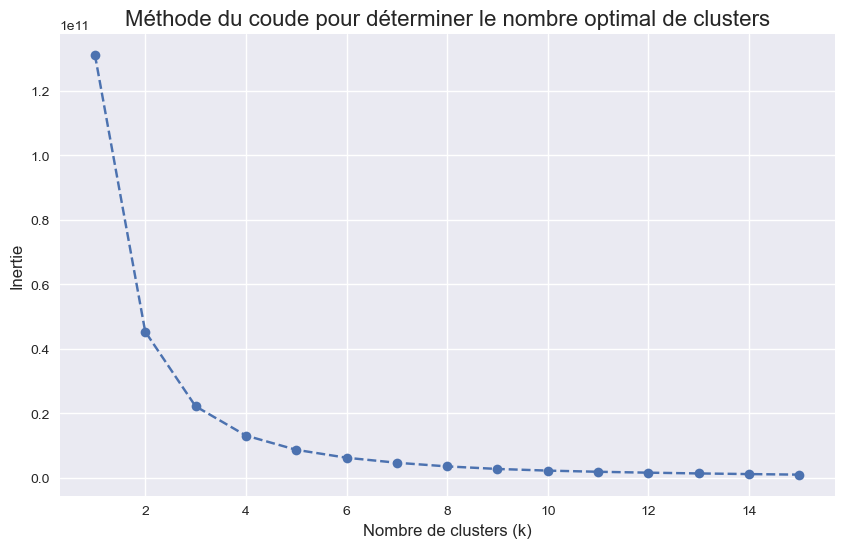

In [31]:
inertias=[]
k_range=range(1,16)

for k in k_range:
    model=KMeans(n_clusters=k,random_state=42,n_init=10)
    model.fit(X)
    inertias.append(model.inertia_)

plt.figure(figsize=(10,6))
plt.plot(k_range,inertias,marker='o', linestyle='--')
plt.title("Méthode du coude pour déterminer le nombre optimal de clusters", fontsize=16)
plt.xlabel("Nombre de clusters (k)", fontsize=12)
plt.ylabel("Inertie", fontsize=12)
plt.show()


Le coude se situe ici à 4, on choisit cette valeur pour K dans la suite.

In [43]:
optimal_k=4

kmeans=KMeans(n_clusters=optimal_k,random_state=42,n_init=10)

clusters=kmeans.fit_predict(X)

df_test['cluster']=clusters

analysis=df_test.groupby('cluster')[['averageRating','numVotes','budget','revenue']].mean()
print(analysis)


         averageRating   numVotes     budget    revenue
cluster                                                
0             6.129849  -0.072559  -0.066081  -0.061227
1             7.083148  10.537308   8.916699   9.434295
2             7.791946  26.970227  12.770744  20.758457
3             6.613292   3.239933   3.794787   2.717170


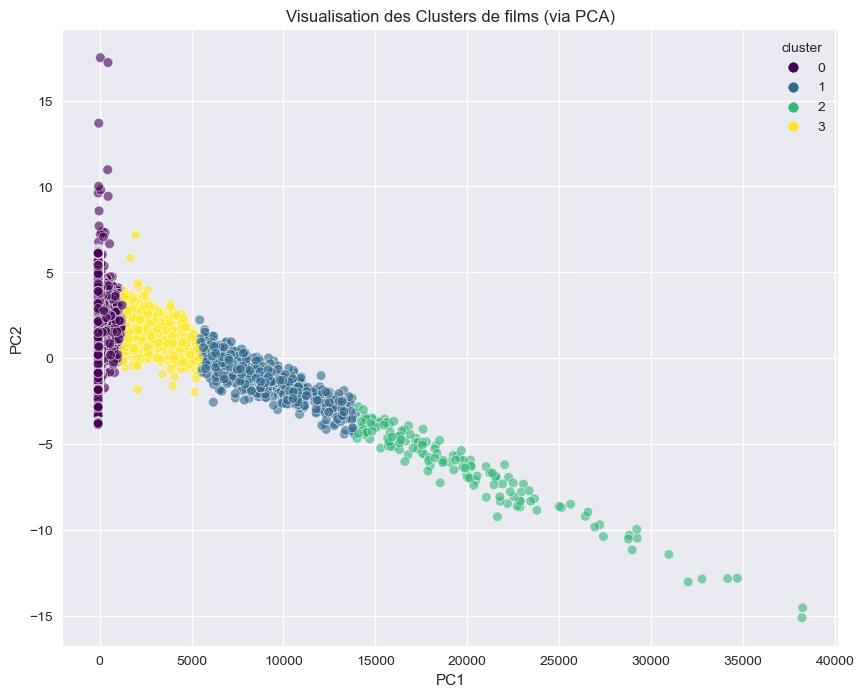

In [44]:
from sklearn.decomposition import PCA

# Réduction de dimension à 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Création d'un petit DF temporaire pour le plot
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = clusters

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='viridis', alpha=0.6)
plt.title('Visualisation des Clusters de films (via PCA)')
plt.show()

On vérifie la cohérence des clusters via 3 ùéthodes: silhouette score, boxplots et sanity check

In [47]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.97


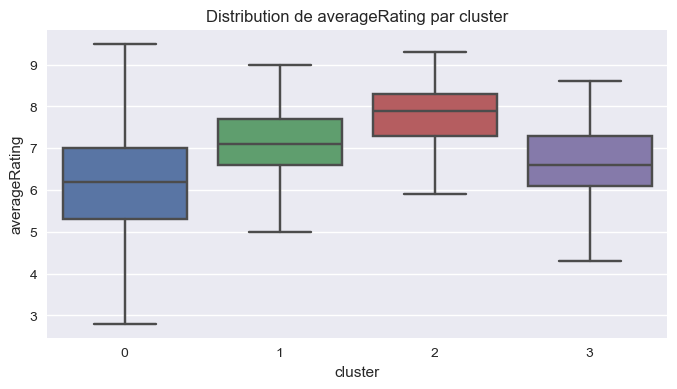

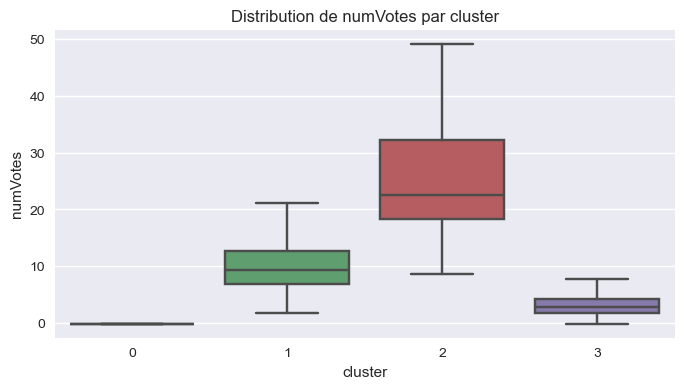

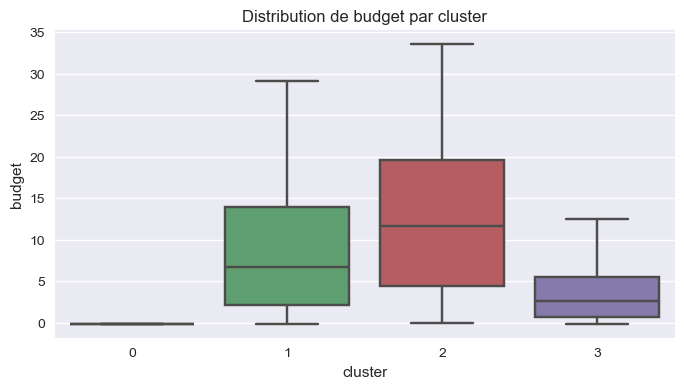

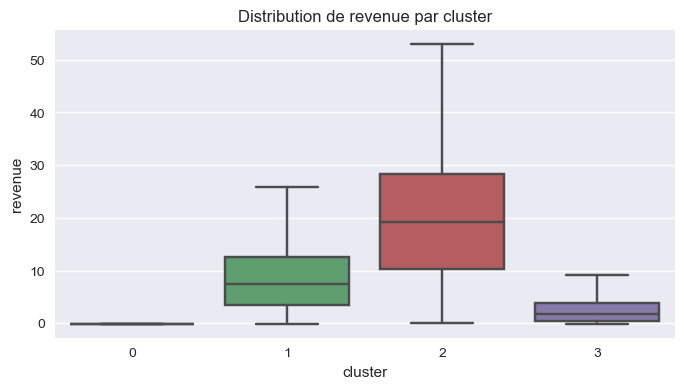

In [50]:
vars_to_check=['averageRating','numVotes','budget','revenue']

for var in vars_to_check:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='cluster',y=var,data=df_test,showfliers=False)
    plt.title(f"Distribution de {var} par cluster")
    plt.show()

In [54]:
for k in range(optimal_k):
               print(f"\n--Cluster {k}--")
               print(df_test[df_test['cluster']==k]['originalTitle'].sample(5).values)


--Cluster 0--
['Yeni Dünya' 'Dream, Above and Beyond' "Heaven's Prisoners"
 'Odette Toulemonde' 'What Lies West']

--Cluster 1--
['Pretty Woman' 'Shaun of the Dead' 'Bird Box' 'Liar Liar'
 "To All the Boys I've Loved Before"]

--Cluster 2--
['Harry Potter and the Prisoner of Azkaban'
 'The Lord of the Rings: The Fellowship of the Ring' 'Fight Club'
 'Batman Begins' 'Inception']

--Cluster 3--
['Heojil kyolshim' "The Girl in the Spider's Web" 'Robin Hood'
 'The Royal Tenenbaums' 'The Power of the Dog']


Le clustering est fait, désormais nous allon appliquer une méthode des K-Nearest Neighbors pour observer la proximité des films au sein des clusters entre eux.

In [71]:
from sklearn.neighbors import NearestNeighbors

knn=NearestNeighbors(n_neighbors=6, metric='euclidean') #le parti est pris de recommander 5 films pour un ici
knn.fit(X)


def recommend_movie(title,df,model_knn,X_data):
    try:
        idx=df[df['originalTitle'].str.lower()==title.lower()].index[0]
    except IndexError:
        return "Film introuvable"
    
    film_vector=X_data.iloc[idx].values.reshape(1,-1)
    distances,indices=model_knn.kneighbors(film_vector)

    print(f"Si vous avez aimé '{df.iloc[idx]['originalTitle']}', vous aimerez peut-être :")
    print("-" * 50)

    for i in range (1, len(indices[0])):
        film_idx=indices[0][i]
        dist=distances[0][i]
        film_title=df.iloc[film_idx]['originalTitle']
        film_genres=df.iloc[film_idx]['genres']
        film_rating=df.iloc[film_idx]['averageRating']
        print(f"{i}. {film_title} (Distance: {dist:.2f})| Genres: {film_genres} | Note IMDB: {film_rating}")

recommend_movie("boogie nights",df_test,knn,X)

Si vous avez aimé 'Boogie Nights', vous aimerez peut-être :
--------------------------------------------------
1. The Number 23 (Distance: 4.98)| Genres: Crime,Mystery,Thriller | Note IMDB: 6.4
2. Army of Darkness (Distance: 6.08)| Genres: Comedy,Horror | Note IMDB: 7.4
3. The Gift (Distance: 9.01)| Genres: Drama,Mystery,Thriller | Note IMDB: 7.0
4. Knock Knock (Distance: 10.31)| Genres: Crime,Thriller | Note IMDB: 4.9
5. Escape from New York (Distance: 13.66)| Genres: Action,Adventure,Sci-Fi | Note IMDB: 7.1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
